In [6]:
import gym
from gym import Env
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from Windy import WindyGridWorldEnv
import random
# Set seaborn plotting type
sns.set(rc={'figure.figsize':(14, 10)})

In [7]:
ALPHA = 0.1 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.1}
GAMMA = 0.9 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.1}
EPSILON = 0.2 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.1}

DECAY = True #@param {type: "boolean"}
DECAY_EPS_UP = 0.6 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.05}
DECAY_EPS_DOWN = 0.1 #@param {type: "slider", min: 0.0, max: 1.0, step: 0.05}
DECAY_EPS_EPISODES = 100 #@param {type: "slider", min: 0, max: 10000, step: 5}

LOG_INTERVAL = 100 #@param {type: "slider", min: 0, max: 1000, step: 10}
NR_EPISODES = 5 #@param {type: "slider", min: 5, max: 10000, step: 5}


# Max iterations standard vi
MAX_ITER = 5e5

In [8]:
# Create two environmenst
# ww = WindyGridworldEnv()
# ww.reset()
# ww.render()
# ww.seed(42)

fl = gym.make("FrozenLake8x8-v1")
fl.reset()
fl.seed(42)

[42]

In [9]:
def choose_action(Q: np.array, state: int, eps: float = 0.0) -> int:
    if random.uniform(0, 1) < eps:
        return random.choice(np.arange(len(Q[state])))
    else:
        return np.argmax(Q[state])

### Bring q and sarsa from old labs

In [10]:
def q_learning(eps: float, 
               decay_eps_down: float or None, 
               decay_eps_up: float or None, 
               alpha: float,
               gamma: float,
               num_episodes: int,
               verbose: bool = False,
               non_reward: bool = False):
    REWARDS = []

    # Table used to keep the utilities for state-action
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for i in range(1, num_episodes + 1):
        state = env.reset()
        has_ended = False
        total_reward = 0
      
        decay_rate = max([(num_episodes - i) / num_episodes, 0]) 
        while not has_ended:
            if DECAY:
                action = choose_action(Q, state, (decay_eps_up - decay_eps_down) * decay_rate + decay_eps_down)
            else:
                action = choose_action(Q, state, eps)
          
            # Do the action
            next_state, reward, has_ended, _ = env.step(action)

            # Cumulate the reward for plotting
            if non_reward:
                if reward != -1:
                    total_reward += reward
            else:    
                total_reward += reward

            # Update the Q(state, action) with the new value
            Q[state][action] = (1 - alpha) * Q[state][action] + alpha * (reward + gamma * max(Q[next_state]))

            # Go to the new state
            state = next_state

        if i % LOG_INTERVAL == 0:
            REWARDS.append(total_reward)
            if verbose:
                print(f"Episode: {i}")
            

    Q_1 = Q
    print("Training Q-Learning finished.\n")
    return Q, REWARDS

In [11]:
env = fl
DECAY = False
Q, REWARDS = q_learning(0.4, None, None, 0.1, 0.9, 10000)

Training Q-Learning finished.



In [12]:
def sarsa(eps: float, 
          decay_eps_down: float or None, 
          decay_eps_up: float or None, 
          alpha: float,
          gamma: float,
          num_episodes: int,
          verbose: bool = False,
          non_reward: bool = False):
  
    REWARDS = []

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for i in range(1, num_episodes + 1):
        state = env.reset()
        has_ended = False
        total_reward = 0

        # Get the action
        decay_rate = max([(num_episodes - i) / num_episodes, 0])

        if DECAY:
            action = choose_action(Q, state, (decay_eps_up - decay_eps_down) * decay_rate + decay_eps_down)
        else:
            action = choose_action(Q, state, eps)

        while not has_ended:
            # Do the action
            next_state, reward, has_ended, _ = env.step(action)

            # Get the next_action from the next_state
            if DECAY:
                next_action = choose_action(Q, state, (decay_eps_up - decay_eps_down) * decay_rate + decay_eps_down)
            else:
                next_action = choose_action(Q, next_state, eps)

            # Cumulate the reward for plotting
            if non_reward:
                if reward != -1: # illegal action is targeted with -1 by default
                    total_reward += reward
            else:    
                total_reward += reward

            # Update the Q(state, action) with the new value
            Q[state][action] = (1 - alpha) * Q[state][action] + alpha * (reward + gamma * Q[next_state][next_action])

            # Go to the new state
            state = next_state

            # Update the action
            action = next_action

        
        if i % LOG_INTERVAL == 0:
            REWARDS.append(total_reward)
            if verbose:
                print(f"Episode: {i}")

    Q_2 = Q
    print("Training SARSA finished.\n")
    return Q, REWARDS

In [13]:
state = env.reset()
has_ended = False
DECAY = False

Q, REWARDS = sarsa(EPSILON, None, None, ALPHA, GAMMA, 10000)

Training SARSA finished.



### N-Step SRASA

In [14]:
def bellman_optimality(env: Env, V: np.ndarray, s: int):
    pi = np.zeros((env.observation_space.n, env.action_space.n))
    e = np.zeros(env.action_space.n)
    
    for a in range(env.action_space.n):
        q = 0
        P = np.array(env.P[s][a])
        (x, y) = P.shape
        for i in range(x):
            s_= int(P[i][1])
            p = P[i][0]
            r = P[i][2]
            q += p * (r + GAMMA * V[s_])
            e[a] = q
        
    m = np.argmax(e)
    pi[s][m] = 1
    
    value = 0
    for a in range(env.action_space.n):
        u = 0
        P = np.array(env.P[s][a])
        (x,y) = np.shape(P)
        for i in range(x):
            
            s_= int(P[i][1])
            p = P[i][0]
            r = P[i][2]
            
            u += p * (r + GAMMA * V[s_])
            
        value += pi[s,a] * u
  
    V[s] = value
    
    return V[s]
        

In [15]:
def extract_arg_max(env: Env, V: np.ndarray, pi: np.ndarray, action: int, s: int):
    e = np.zeros(env.action_space.n)
    
    for a in range(env.action_space.n):                         # iterate for every action possible 
        q=0
        P = np.array(env.P[s][a])                   
        (x,y) = np.shape(P)                             # for Bellman Equation 
        
        for i in range(x):                              # iterate for every possible states
            s_= int(P[i][1])                            # S' - Sprime - possible succesor states
            p = P[i][0]                                 # Transition Probability P(s'|s,a) 
            r = P[i][2]                                 # Reward
            
            q += p * (r + GAMMA * V[s_])                      # calculate action_ value q(s|a)
            e[a] = q
            
    m = np.argmax(e) 
    action[s]=m                                           # Take index which has maximum value 
    pi[s][m] = 1                                        # update pi(a|s) 

    return pi

In [16]:
def standard_vi(env: Env):
    """
        Naive: Value Iteration Algorithm
    """
    V = np.zeros(env.observation_space.n)
    iterations_counter = 0
    
    values_deltas = []
    while iterations_counter < MAX_ITER:
        delta = 0

        for s in range(env.observation_space.n):
            iterations_counter += 1
            v = V[s]
            V[s] = bellman_optimality(env=env, V=V, s=s)
            delta = max(delta, abs(v - V[s]))
            values_deltas.append(np.linalg.norm(v - V[s]))

        if delta < 1e-5: 
            break
    
    pi = np.zeros((env.observation_space.n, env.action_space.n)) 
    action = np.zeros((env.observation_space.n))
    for s in range(env.observation_space.n):
        pi = extract_arg_max(env=env, V=V, pi=pi, action=action, s=s)  # extract optimal policy using action value 
    
    print("Total iterations spent: {}".format(iterations_counter))
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot([i for i in range(iterations_counter)], values_deltas, label="||V_(k+1)(s) - V_k(s)||") # Or however the Axes was created.
    ax.legend()
    ax.get_legend().set_title("Standard Value iteration covergence")
    return V, pi, action

Total iterations spent: 3328


(64,)

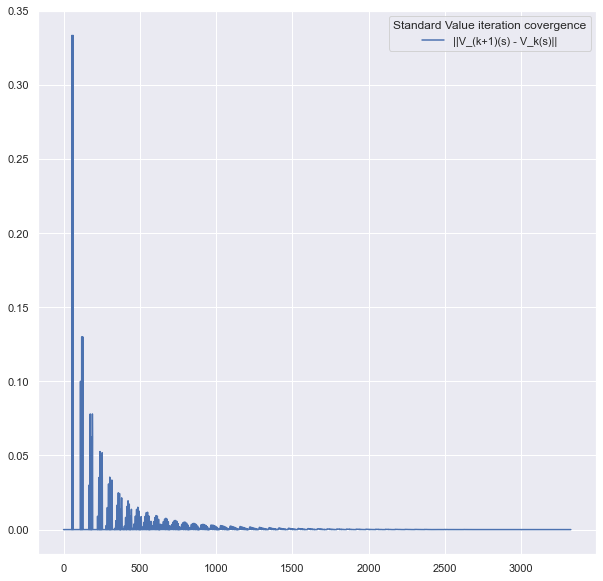

In [17]:
### Ground truth
V, pi, _ = standard_vi(env=fl)
V.shape

In [18]:
def n_satep_sarsa(
                  env: Env,
                  eps: float,
                  gamma: float,
                  lr: float,
                  num_rounds: int = 20, 
                  steps: int = 5
):
     Q = np.zeros((env.observation_space.n, env.action_space.n))

     all_rewards = []
     for _ in range(num_rounds):
        state = env.reset()
        t = 0
        T = np.inf
        action = choose_action(Q, state, eps)

        actions = [action]
        states = [state]
        rewards = [0]
        
        while True:
            if t < T:
                next_state, reward, has_ended, _ = env.step(action)

                states.append(next_state)
                rewards.append(reward)
                
                if has_ended:
                    T = t + 1
                else:
                    next_action = choose_action(Q, next_state, eps)
                    actions.append(action)
                    
            tau = t - steps + 1
            if tau >= 0:
                G = 0
                
                for i in range(tau + 1, min(tau + steps + 1, T + 1)):
                    G += np.power(gamma, i - tau - 1) * rewards[i]
                if tau + steps < T:
                    state_action = (states[tau + steps], actions[tau + steps])
                    G += np.power(gamma, steps) * Q[state_action[0]][state_action[1]]
                
                state_action = (states[tau], actions[tau])
                Q[state_action[0]][state_action[1]] += lr * (
                            G - Q[state_action[0]][state_action[1]])

            if tau == T - 1:
                break

            t += 1
            
        all_rewards.append(rewards)
     return Q, all_rewards
        

In [19]:
Q, r = n_satep_sarsa(env=fl, eps=EPSILON, gamma=GAMMA, lr=ALPHA)
r

[[0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
 

Running estimation for lr=0.0 and step=1
(4, 64)
Running estimation for lr=0.05263157894736842 and step=1
(4, 64)
Running estimation for lr=0.10526315789473684 and step=1
(4, 64)
Running estimation for lr=0.15789473684210525 and step=1
(4, 64)
Running estimation for lr=0.21052631578947367 and step=1
(4, 64)
Running estimation for lr=0.2631578947368421 and step=1
(4, 64)
Running estimation for lr=0.3157894736842105 and step=1
(4, 64)
Running estimation for lr=0.3684210526315789 and step=1
(4, 64)
Running estimation for lr=0.42105263157894735 and step=1
(4, 64)
Running estimation for lr=0.47368421052631576 and step=1
(4, 64)
Running estimation for lr=0.5263157894736842 and step=1
(4, 64)
Running estimation for lr=0.5789473684210527 and step=1
(4, 64)
Running estimation for lr=0.631578947368421 and step=1
(4, 64)
Running estimation for lr=0.6842105263157894 and step=1
(4, 64)
Running estimation for lr=0.7368421052631579 and step=1
(4, 64)
Running estimation for lr=0.7894736842105263 and s

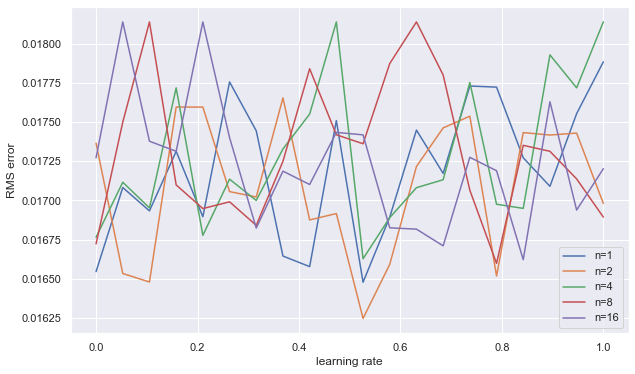

In [20]:
actual_state_values = V

lr_range = np.linspace(0.0, 1.0, num=20)
steps_range = np.power(2, range(5))
episodes = 200

sq_errors = {}

for n in steps_range:
    ers = []
    for lr in lr_range:
        print("Running estimation for lr={} and step={}".format(lr, n))
        Q, rw = n_satep_sarsa(env=fl, eps=EPSILON, gamma=GAMMA, lr=ALPHA, num_rounds=episodes)
        estimate_state_values = Q.reshape((-1, 64))
        print(estimate_state_values.shape)
        ers.append(np.mean([er**2 for er in actual_state_values - estimate_state_values]))
    sq_errors[n] = ers

plt.figure(figsize=[10, 6])

for n in steps_range:
    plt.plot(lr_range, sq_errors[n], label="n={}".format(n))

plt.xlabel('learning rate')
plt.ylabel('RMS error')
plt.legend()

In [ ]:
### Ground truth
V, pi, _ = standard_vi(env=ww)
V.shape

In [ ]:
actual_state_values = V

lr_range = np.linspace(0.0, 1.0, num=20)
steps_range = np.power(2, range(5))
episodes = 200

sq_errors = {}

for n in steps_range:
    ers = []
    for lr in lr_range:
        print("Running estimation for lr={} and step={}".format(lr, n))
        Q, rw = n_satep_sarsa(env=ww, eps=EPSILON, gamma=GAMMA, lr=ALPHA, num_rounds=episodes)
        estimate_state_values = Q.reshape((-1, 70))
        ers.append(np.mean([er**2 for er in actual_state_values - estimate_state_values]))
    sq_errors[n] = ers

plt.figure(figsize=[10, 6])

for n in steps_range:
    plt.plot(lr_range, sq_errors[n], label="n={}".format(n))

plt.xlabel('learning rate')
plt.ylabel('RMS error')
plt.legend()